# Localizer Behavioral Data & Onset Generation

In [83]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import os

from scipy.stats import norm
Z = norm.ppf

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
# %R require(lme4)
# %R require(lmerTest)

## Gather experiment info

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data/')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')

In [3]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info.group.value_counts()

stress     20
control    20
Name: group, dtype: int64

In [7]:
# Remove bad performance subjs
subj_info = subj_info.loc[~subj_info.subid.isin([10, 21])]
subj_info.group.value_counts()

stress     20
control    18
Name: group, dtype: int64

## Load in data

In [17]:
dl = pd.DataFrame()

for subid in subj_info.subid:
    print subid
    
    # add study file
    study_file = op.join(dirs['datadir'], str(subid), str(subid) + '_behav_localizer.csv')
    d = pd.read_csv(study_file)
    d['subid'] = subid
    dl = dl.append(d, ignore_index=True)
    
# Merge with subj_info
dl = dl.merge(subj_info, on='subid', how='outer')

3
4
5
6
7
9
11
12
13
14
15
16
18
19
20
22
23
24
26
29
30
31
34
35
38
40
41
43
44
45
46
48
49
50
54
55
56
57


In [18]:
dl.head()

index  run  trial    onset  duration         cond  rep resp  acc    respRT  \
0      1    1      1  12.0018    1.6001  virtualtown    0   NR    0  999.0000   
1      2    1      2  13.6022    1.5986  virtualtown    0   NR    0  999.0000   
2      3    1      3  15.2010    1.6000  virtualtown    0   NR    0  999.0000   
3      4    1      4  16.8012    1.6001  virtualtown    1    1    1    0.5156   
4      5    1      5  18.4015    1.5996  virtualtown    0   NR    0  999.0000   

  ISIresp  ISIacc  ISIrespRT  subid    group  remove  
0      NR       0   999.0000      3  control     NaN  
1       0       1     0.0579      3  control     NaN  
2       0       1     0.0217      3  control     NaN  
3      NR       0   999.0000      3  control     NaN  
4       0       1     0.0483      3  control     NaN

### Deal with no responses (NR): Set ISI resp as resp

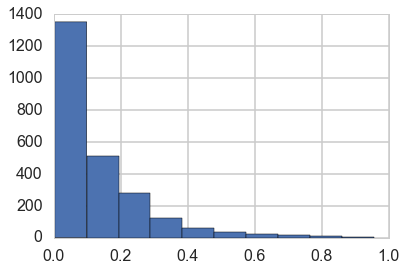

In [21]:
dl.loc[(dl.resp == 'NR') & (dl.ISIresp != 'NR'), 'ISIrespRT'].hist()

In [25]:
dl.respRT[dl.resp == 'NR'] = dl.ISIrespRT[dl.resp == 'NR'] + .6 # adjust for stimTime
dl.acc[dl.resp == 'NR'] = dl.ISIacc[dl.resp == 'NR']
dl.resp[dl.resp == 'NR'] = dl.ISIresp[dl.resp == 'NR']

drop_cols = ['ISIrespRT', 'ISIresp', 'ISIacc', 'remove', 'index']
dl.drop(drop_cols, 1, inplace=True)

/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/sgagnon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
dl.resp.value_counts()

0     9205
1     4290
NR    3225
Name: resp, dtype: int64

count    13480.000000
mean         0.489186
std          0.149519
min          0.022700
25%          0.392000
50%          0.465000
75%          0.553400
max          1.554900
Name: respRT, dtype: float64


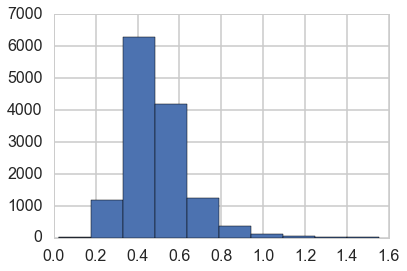

In [28]:
print dl.loc[(dl.resp != 'NR') & (dl.cond != 'rest'), 'respRT'].describe()
dl.loc[(dl.resp != 'NR') & (dl.cond != 'rest'), 'respRT'].hist()

In [29]:
# Correct duration of image trials by subtracting ITI (1s fix)
dl['duration_adj'] = dl.duration
dl.loc[dl.cond != 'rest', 'duration_adj'] = dl.loc[dl.cond != 'rest', 'duration_adj'] - 1 # subtract ITI

In [30]:
dl.head()

run  trial    onset  duration         cond  rep resp  acc    respRT  subid  \
0    1      1  12.0018    1.6001  virtualtown    0   NR    0  999.6000      3   
1    1      2  13.6022    1.5986  virtualtown    0    0    1    0.6579      3   
2    1      3  15.2010    1.6000  virtualtown    0    0    1    0.6217      3   
3    1      4  16.8012    1.6001  virtualtown    1    1    1    0.5156      3   
4    1      5  18.4015    1.5996  virtualtown    0    0    1    0.6483      3   

     group  duration_adj  
0  control        0.6001  
1  control        0.5986  
2  control        0.6000  
3  control        0.6001  
4  control        0.5996

In [33]:
# for some reason these 5 trials have short durations (lag on display? hold down button box?)
dl.loc[dl.duration_adj < 0]

run  trial     onset  duration      cond  rep resp  acc    respRT  \
1723     2    184  440.0266    0.7748  fruitveg    0   NR    0  999.6000   
3038     2    179  432.0264    0.7748  fruitveg    0    0    1    1.1449   
6288     1    129  310.0202    0.7809      tool    0   NR    0  999.6000   
7081     1     42  104.0113    0.3888      tool    1   NR    0  999.6000   
15414    1     15   44.0091    0.3916      tool    0   NR    0  999.6000   

       subid    group  duration_adj  
1723       6  control       -0.2252  
3038      11  control       -0.2252  
6288      20   stress       -0.2191  
7081      23  control       -0.6112  
15414     55   stress       -0.6084

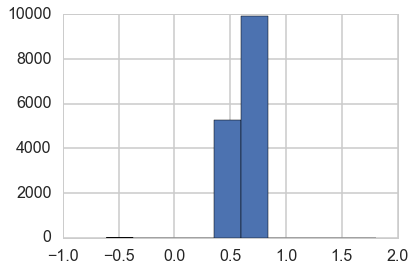

In [32]:
dl.loc[dl.cond != 'rest', 'duration_adj'].hist()

### Remove time for lead-in (8 s)

In [34]:
dl['onset_adj'] = dl.onset - 8 # (only remove 8s, even though have 12s could drop, since nav drop 4)
dl.head()

run  trial    onset  duration         cond  rep resp  acc    respRT  subid  \
0    1      1  12.0018    1.6001  virtualtown    0   NR    0  999.6000      3   
1    1      2  13.6022    1.5986  virtualtown    0    0    1    0.6579      3   
2    1      3  15.2010    1.6000  virtualtown    0    0    1    0.6217      3   
3    1      4  16.8012    1.6001  virtualtown    1    1    1    0.5156      3   
4    1      5  18.4015    1.5996  virtualtown    0    0    1    0.6483      3   

     group  duration_adj  onset_adj  
0  control        0.6001     4.0018  
1  control        0.5986     5.6022  
2  control        0.6000     7.2010  
3  control        0.6001     8.8012  
4  control        0.5996    10.4015

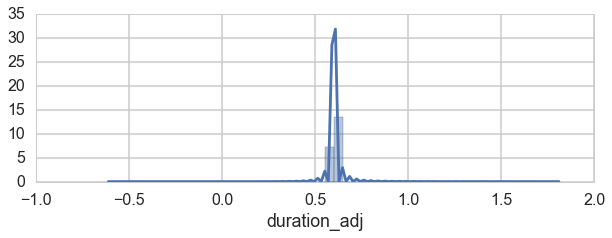

In [35]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(111)
sns.distplot(dl[dl.duration_adj < 5].duration_adj, ax=ax)

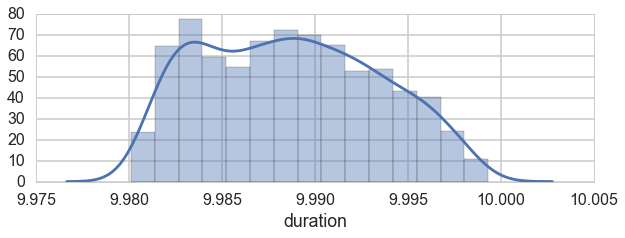

In [36]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(111)
sns.distplot(dl[dl.duration_adj > 5].duration, ax=ax)

## Analyze RTs (for correct responses)

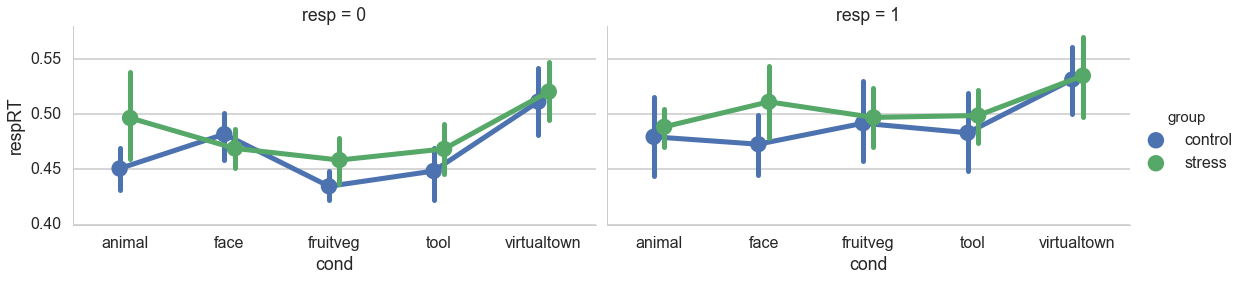

In [137]:
dl_resp = dl[(dl.resp != 'NR') & (dl.cond != 'rest')]
medians = dl_resp.groupby(['subid', 'group', 'cond', 'rep', 'resp', 'acc']).median().reset_index()

sns.factorplot(x='cond', hue='group', y='respRT',
               col='resp',
               units='subid', ci=68, dodge=.1,
               data=medians.loc[dl.acc == 1], aspect=2)

In [152]:
medians.respRT.describe()

count    642.000000
mean       0.491247
std        0.128503
min        0.022700
25%        0.414475
50%        0.460950
75%        0.538687
max        1.396400
Name: respRT, dtype: float64

In [138]:
medians.head()

subid    group    cond  rep resp  acc  run  trial      onset  duration  \
0      3  control  animal    0    0    1  2.0   78.0  194.00070    1.5998   
1      3  control  animal    1    0    0  2.0   87.0  208.40030    1.6008   
2      3  control  animal    1    1    1  1.0   76.0  182.40110    1.5996   
3      3  control    face    0    0    1  1.0   89.5  220.80100    1.5998   
4      3  control    face    0    1    0  1.5   56.5  142.80115    1.5996   

    respRT  duration_adj  onset_adj  
0  0.53610        0.5998  186.00070  
1  0.47100        0.6008  200.40030  
2  0.45870        0.5996  174.40110  
3  0.56030        0.5998  212.80100  
4  0.91205        0.5996  134.80115

In [139]:
medians.to_csv('/Volumes/group/awagner/sgagnon/SST/analysis/behav/localizer_medianrt.csv')

## Analyze Accuracy

#### Calculate dprimes

In [122]:
# get counts for condition/response mappings
dl_counts = dl.loc[dl.cond != 'rest'].pivot_table(index=['subid', 'group', 'rep', 'cond'], 
                           columns='resp', values='acc', 
                           aggfunc='count', fill_value=0).reset_index()

# get totals per rep type (1-back:1, other:0)
dl_counts['total'] = dl_counts[['0', '1', 'NR']].sum(axis=1)

# get counts per type
dl_counts['diff_rate'] = dl_counts['0'] / dl_counts.total
dl_counts['repeat_rate'] = dl_counts['1'] / dl_counts.total
dl_counts['NR_rate'] = dl_counts['NR'] / dl_counts.total

hit_rates = dl_counts.loc[dl_counts.rep == 1, ['subid', 'group', 'cond', 'repeat_rate']]
fa_rates = dl_counts.loc[dl_counts.rep == 0, ['subid', 'group', 'cond', 'repeat_rate']]

hit_rates.rename(columns={'repeat_rate':'hit_rate'}, inplace=True)
fa_rates.rename(columns={'repeat_rate':'fa_rate'}, inplace=True)

rates = hit_rates.merge(fa_rates)

# replace 0/1 rates:
rates.loc[rates.fa_rate == 0, 'fa_rate'] = .5/56
rates.loc[rates.fa_rate == 1, 'fa_rate'] = 1-.5/56

rates.loc[rates.hit_rate == 0, 'hit_rate'] = .5/24
rates.loc[rates.hit_rate == 1, 'hit_rate'] = 1-.5/24

rates['d'] = Z(rates.hit_rate) - Z(rates.fa_rate)

rates.groupby('cond').describe()

resp            d                                                              \
            count      mean       std       min       25%       50%       75%   
cond                                                                            
animal       38.0  3.102217  1.298400 -3.028361  2.963360  3.335989  3.811763   
face         38.0  3.132077  1.249122 -2.723191  2.922561  3.483160  3.751561   
fruitveg     38.0  3.087784  1.266482 -2.799235  2.913560  3.250515  3.751561   
tool         38.0  3.163207  1.213686 -2.374521  3.067587  3.293252  3.751561   
virtualtown  38.0  2.685892  1.198407 -2.828473  2.436848  2.809196  3.237111   

resp                  fa_rate            ...   hit_rate           subid  \
                  max   count      mean  ...        75%       max count   
cond                                     ...                              
animal       4.137000    38.0  0.050987  ...   0.947917  0.979167  38.0   
face         4.405401    38.0  0.049107  ...   0.916667  0.979167  38.0   
fruitveg     4.405401    38.0  0.050047  ...   0.947917  0.979167  38.0   
tool         4.405401    38.0  0.050517  ...   0.947917  0.979167  38.0   
virtualtown  4.405401    38.0  0.068844  ...   0.916667  0.979167  38.0   

resp                                                             
                  mean       std  min    25%   50%    75%   max  
cond                                                             
animal       28.736842  16.89504  3.0  14.25  27.5  43.75  57.0  
face         28.736842  16.89504  3.0  14.25  27.5  43.75  57.0  
fruitveg     28.736842  16.89504  3.0  14.25  27.5  43.75  57.0  
tool         28.736842  16.89504  3.0  14.25  27.5  43.75  57.0  
virtualtown  28.736842  16.89504  3.0  14.25  27.5  43.75  57.0  

[5 rows x 32 columns]

In [121]:
rates.median()

resp
subid       27.500000
hit_rate     0.875000
fa_rate      0.017857
d            3.250515
dtype: float64

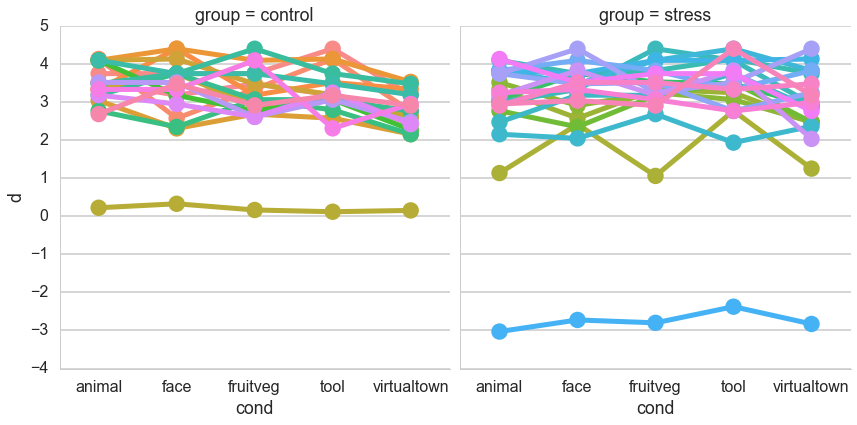

In [151]:
g = sns.factorplot(x='cond', y='d', hue='subid', col='group', size=6,
              data=rates, alpha=.5, legend=False)

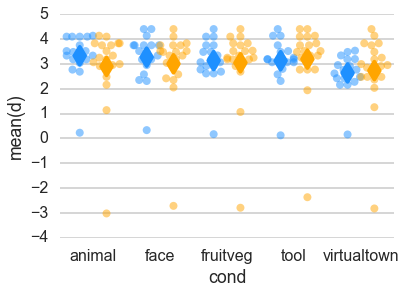

In [123]:
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.swarmplot(x='cond', y='d', hue='group', split=True,
              data=rates, alpha=.5, size=8,
              palette=['dodgerblue', 'orange'])

sns.pointplot(x='cond', y='d', hue='group',
              data=rates, alpha=.25, dodge=.4,
              join=False,
              markers="d", scale=1, ci=None,
              palette=['dodgerblue', 'orange'])

# Improve the legend 
ax.legend_.remove()

In [125]:
print rates.loc[rates.d < 1]
dl_counts.loc[dl_counts.subid.isin([13, 40])]

resp  subid    group         cond  hit_rate   fa_rate         d
40       13  control       animal  0.500000  0.410714  0.225708
41       13  control         face  0.541667  0.410714  0.330341
42       13  control     fruitveg  0.458333  0.392857  0.167247
43       13  control         tool  0.458333  0.410714  0.121074
44       13  control  virtualtown  0.416667  0.357143  0.155678
125      40   stress       animal  0.020833  0.839286 -3.028361
126      40   stress         face  0.041667  0.839286 -2.723191
127      40   stress     fruitveg  0.041667  0.857143 -2.799235
128      40   stress         tool  0.083333  0.839286 -2.374521
129      40   stress  virtualtown  0.020833  0.785714 -2.828473


resp  subid    group  rep         cond   0   1  NR  total  diff_rate  \
80       13  control    0       animal  24  23   9     56   0.428571   
81       13  control    0         face  25  23   8     56   0.446429   
82       13  control    0     fruitveg  26  22   8     56   0.464286   
83       13  control    0         tool  25  23   8     56   0.446429   
84       13  control    0  virtualtown  26  20  10     56   0.464286   
85       13  control    1       animal  10  12   2     24   0.416667   
86       13  control    1         face  11  13   0     24   0.458333   
87       13  control    1     fruitveg  13  11   0     24   0.541667   
88       13  control    1         tool  12  11   1     24   0.500000   
89       13  control    1  virtualtown  14  10   0     24   0.583333   
250      40   stress    0       animal   0  47   9     56   0.000000   
251      40   stress    0         face   0  47   9     56   0.000000   
252      40   stress    0     fruitveg   0  48   8     56   0.000000   
253      40   stress    0         tool   0  47   9     56   0.000000   
254      40   stress    0  virtualtown   0  44  12     56   0.000000   
255      40   stress    1       animal   0   0  24     24   0.000000   
256      40   stress    1         face   0   1  23     24   0.000000   
257      40   stress    1     fruitveg   0   1  23     24   0.000000   
258      40   stress    1         tool   0   2  22     24   0.000000   
259      40   stress    1  virtualtown   0   0  24     24   0.000000   

resp  repeat_rate   NR_rate  
80       0.410714  0.160714  
81       0.410714  0.142857  
82       0.392857  0.142857  
83       0.410714  0.142857  
84       0.357143  0.178571  
85       0.500000  0.083333  
86       0.541667  0.000000  
87       0.458333  0.000000  
88       0.458333  0.041667  
89       0.416667  0.000000  
250      0.839286  0.160714  
251      0.839286  0.160714  
252      0.857143  0.142857  
253      0.839286  0.160714  
254      0.785714  0.214286  
255      0.000000  1.000000  
256      0.041667  0.958333  
257      0.041667  0.958333  
258      0.083333  0.916667  
259      0.000000  1.000000

In [140]:
rates.to_csv('/Volumes/group/awagner/sgagnon/SST/analysis/behav/localizer_dprime.csv')

## Generate onset files

Each csv file must have a column for `run`, `condition`, `onset`, `duration`, and `value`

In [16]:
dl.loc[dl.cond != 'rest', 'duration_adj'].min()

-0.61119999999999997

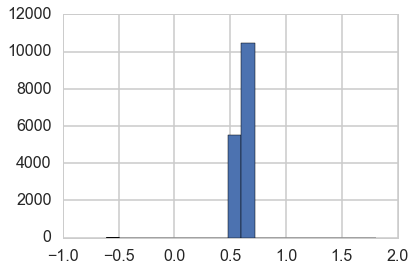

In [17]:
dl.loc[(dl.cond != 'rest'), 'duration_adj'].hist(bins=20)

In [18]:
dl.loc[dl.duration_adj < .5]

run  trial     onset  duration      cond  rep resp  acc    respRT  \
1723     2    184  440.0266    0.7748  fruitveg    0   NR    0  999.6000   
3478     2    179  432.0264    0.7748  fruitveg    0    0    1    1.1449   
6728     1    129  310.0202    0.7809      tool    0   NR    0  999.6000   
7961     1     42  104.0113    0.3888      tool    1   NR    0  999.6000   
16294    1     15   44.0091    0.3916      tool    0   NR    0  999.6000   

       subid    group  duration_adj  onset_adj  
1723       6  control       -0.2252   432.0266  
3478      11  control       -0.2252   424.0264  
6728      20   stress       -0.2191   302.0202  
7961      23  control       -0.6112    96.0113  
16294     55   stress       -0.6084    36.0091

In [19]:
output_filename = 'localizer_cond.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

for subid in subj_info.subid:
    print subid
    
    dsub = dl[(dl.subid == subid) & (dl.cond != 'rest')]
    ddesign = pd.DataFrame({'run': dsub.run,
                            'condition': dsub.cond,
                            'onset': dsub.onset_adj,
                            'duration': .6,
                            'value': 1})
    if subid < 10:
        subname='sst0'+str(subid)
    else:
        subname='sst'+str(subid)
    
    sub_output_dir = op.join(output_dir, subname, 'design')
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

3
4
5
6
7
9
10
11
12
13
14
15
16
18
19
20
21
22
23
24
26
29
30
31
34
35
38
40
41
43
44
45
46
48
49
50
54
55
56
57


In [20]:
output_filename = 'localizer_cond_mvpa.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

# for subid in subj_info.subid:
for subid in subj_info.subid:
    print subid
    dsub = dl[(dl.subid == subid)] # & (dl.cond != 'rest')
    ddesign = pd.DataFrame({'run': dsub.run + 12, #update w/nav runs
                            'condition': dsub.cond,
                            'onset': dsub.onset_adj,
                            'duration': .6,
                            'value': 1})
    
    if subid < 10:
        subname='sst0'+str(subid)
    else:
        subname='sst'+str(subid)
        
    ddesign.to_csv(op.join(output_dir, subname,
                           'design', output_filename), index=False)

3
4
5
6
7
9
10
11
12
13
14
15
16
18
19
20
21
22
23
24
26
29
30
31
34
35
38
40
41
43
44
45
46
48
49
50
54
55
56
57


In [19]:
dl.head()

run  trial    onset  duration         cond  rep resp  acc    respRT  subid  \
0    1      1  12.0018    1.6001  virtualtown    0   NR    0  999.6000      3   
1    1      2  13.6022    1.5986  virtualtown    0    0    1    0.6579      3   
2    1      3  15.2010    1.6000  virtualtown    0    0    1    0.6217      3   
3    1      4  16.8012    1.6001  virtualtown    1    1    1    0.5156      3   
4    1      5  18.4015    1.5996  virtualtown    0    0    1    0.6483      3   

     group  duration_adj  onset_adj  
0  control        0.6001     4.0018  
1  control        0.5986     5.6022  
2  control        0.6000     7.2010  
3  control        0.6001     8.8012  
4  control        0.5996    10.4015

In [20]:
dl.cond.unique()

array(['virtualtown', 'rest', 'tool', 'animal', 'fruitveg', 'face'], dtype=object)

In [24]:
dl['cond_merge'] = dl.cond
dl.loc[dl.cond_merge.isin(['fruitveg', 'tool']), 'cond_merge'] = 'object'
dl.cond_merge.unique()

array(['virtualtown', 'rest', 'object', 'animal', 'face'], dtype=object)

In [27]:
output_filename = 'localizer_cond_mergeobj_mvpa.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

# for subid in subj_info.subid:
for subid in subj_info.subid:
    
    print subid
    
    # deal with crash subjs
    if subid in [40, 46, 48, 54]:
        run_shift = 13
    else:
        run_shift = 12
    
    dsub = dl[(dl.subid == subid)] # & (dl.cond != 'rest')
    ddesign = pd.DataFrame({'run': dsub.run + run_shift, #update w/nav runs
                            'condition': dsub.cond_merge,
                            'onset': dsub.onset_adj,
                            'duration': .6,
                            'value': 1})
    
    if subid < 10:
        subname='sst0'+str(subid)
    else:
        subname='sst'+str(subid)
        
    ddesign.to_csv(op.join(output_dir, subname,
                           'design', output_filename), index=False)

3
4
5
6
7
9
10
11
12
13
14
15
16
18
19
20
21
22
23
24
26
29
30
31
34
35
38
40
41
43
44
45
46
48
49
50
54
55
56
57
